# OLID-BR (EDA)

In this notebook, we will explore the data in the OLID-BR dataset.

In [1]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent.parent))

In [2]:
from dotenv import load_dotenv

# Initialize the env vars
load_dotenv("../../.env")

True

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from typing import List
from ast import literal_eval
from pandas_profiling import ProfileReport
from kaggle.api.kaggle_api_extended import KaggleApi
from src.settings import AppSettings
from src.s3 import get_json_from_s3
from src.utils import get_toxic_substrings

%matplotlib inline

args = AppSettings()

In [5]:
print("Downloading data from Kaggle")
kaggle = KaggleApi()
kaggle.authenticate()
kaggle.dataset_download_file(dataset="olidbr", file_name="olidbr.csv")

data = pd.read_csv("olidbr.csv")

data.toxic_spans = data.toxic_spans.apply(lambda x: literal_eval(x) if pd.notnull(x) else x)

Path("olidbr.csv").unlink()

print(f"Shape: {data.shape}")
data.head()

Shape: (706, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,6391e3dbb12848ac8ef6131edf2d69f9,USER Canalha URL,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12]",False,False,True,False,False,False,False,False,False,False,False
1,5a21508c2afc4c3295137451baf8b981,USER VTNSC FDP,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12, 13]",False,False,True,False,False,False,True,False,False,False,False
2,060b0390f99041cd8cd38ca5a2b66907,USER O partido do Kim votou à favor do fundão....,OFF,TIN,IND,NaN,False,False,True,False,False,False,False,False,False,False,False
3,3264fc0b06974c2daf423a9e5998d003,USER Grande homem. Em um país de covardes. Ete...,OFF,TIN,GRP,"[34, 35, 36, 37, 38, 39, 40, 41]",False,False,True,False,False,False,False,False,False,False,False
4,002bced1b7444833bbe5e054c5aa6512,USER USER QAnon Brasil é um bicho estranho. Ob...,OFF,TIN,IND,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...",False,False,True,False,False,False,True,False,False,False,False


In [6]:
kaggle.dataset_download_file(dataset="olidbr", file_name="metadata.csv")

metadata = pd.read_csv("metadata.csv")

Path("metadata.csv").unlink()

print(f"Shape: {metadata.shape}")
metadata.head()

Shape: (1520, 11)


,id,source,created_at,collected_at,toxicity_score,category,annotator_id,gender,age,education_level,annotator_type
0,6391e3dbb12848ac8ef6131edf2d69f9,Twitter,2021-12-28T15:52:02+00:00,2021-12-28T09:27:13.610956,0.7424,NaN,NaN,NaN,NaN,NaN,NaN
1,6391e3dbb12848ac8ef6131edf2d69f9,NaN,NaN,NaN,NaN,NaN,32.0,Female,30.0,Bachelor's degree,Volunteer
2,6391e3dbb12848ac8ef6131edf2d69f9,NaN,NaN,NaN,NaN,NaN,1.0,Male,28.0,Bachelor's degree,Researcher
3,5a21508c2afc4c3295137451baf8b981,Twitter,2021-12-28T16:58:00+00:00,2021-12-28T09:27:13.610956,0.8707,NaN,NaN,NaN,NaN,NaN,NaN
4,5a21508c2afc4c3295137451baf8b981,NaN,NaN,NaN,NaN,NaN,32.0,Female,30.0,Bachelor's degree,Volunteer


## Profiling

In the next cell, we will generate a profiling report for the OLID-BR dataset.

It will provide a summary of the dataset, it will be saved in the `reports` folder.

In [7]:
profile = ProfileReport(data, title="OLID-BR Pilot",
                        explorative=True, dark_mode=True)

profile.to_file("../reports/olidbr_pilot.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


In [8]:
profile.to_notebook_iframe()

## Data Exploration

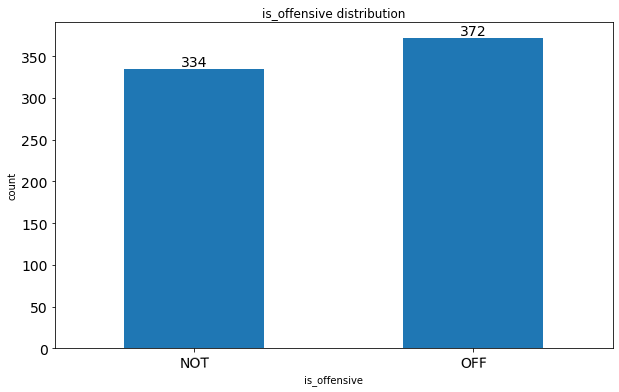

In [9]:
df_temp = data[["text", "is_offensive"]].groupby("is_offensive").count()
df_temp.reset_index(inplace=True)

ax = df_temp.plot(x="is_offensive", kind="bar",
                 legend=False, figsize=(10, 6),
                 xlabel="is_offensive", ylabel="count", fontsize=14,
                 rot=1, title="is_offensive distribution")

for container in ax.containers:
    ax.bar_label(container, fontsize=14)

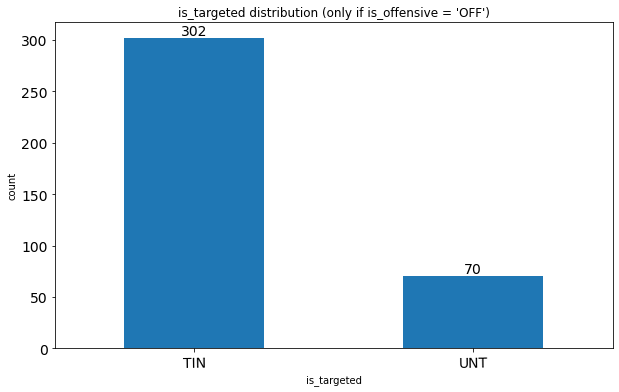

In [10]:
df_temp = data[data["is_offensive"] == "OFF"][["text", "is_targeted"]].groupby("is_targeted").count()
df_temp.reset_index(inplace=True)

ax = df_temp.plot(x="is_targeted", kind="bar",
                 legend=False, figsize=(10, 6),
                 xlabel="is_targeted", ylabel="count", fontsize=14,
                 rot=1, title="is_targeted distribution (only if is_offensive = 'OFF')")

for container in ax.containers:
    ax.bar_label(container, fontsize=14)

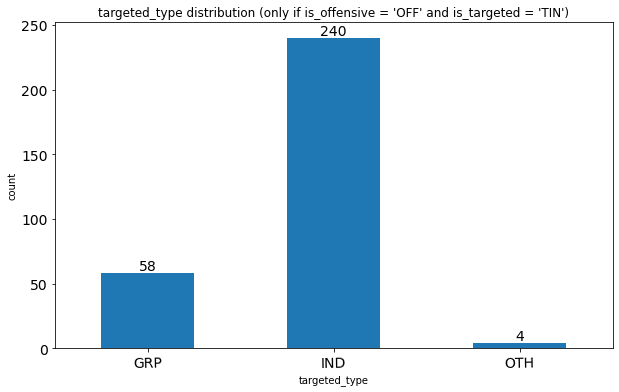

In [11]:
df_temp = data[(data["is_offensive"] == "OFF") & (data["is_targeted"] == "TIN")]
df_temp = df_temp[["text", "targeted_type"]].groupby("targeted_type").count()
df_temp.reset_index(inplace=True)

ax = df_temp.plot(x="targeted_type", kind="bar",
                 legend=False, figsize=(10, 6),
                 xlabel="targeted_type", ylabel="count", fontsize=14,
                 rot=1, title="targeted_type distribution (only if is_offensive = 'OFF' and is_targeted = 'TIN')")

for container in ax.containers:
    ax.bar_label(container, fontsize=14)

## Word Cloud for toxic words

In the next cells, we will generate a word cloud for the toxic words in the dataset.

First, we will get the substrings based on `toxic_spans` field.

Then, we will generate a word cloud for the toxic words.

In [12]:
toxic_substrs = []

for row in data.to_dict(orient="records"):
    if isinstance(row.get("toxic_spans"), list) and len(row.get("toxic_spans")) > 0:
        toxic_substrs.extend(get_toxic_substrings(row["text"], row["toxic_spans"]))

print(f"toxic_substrs: {len(toxic_substrs)}")

toxic_substrs: 372


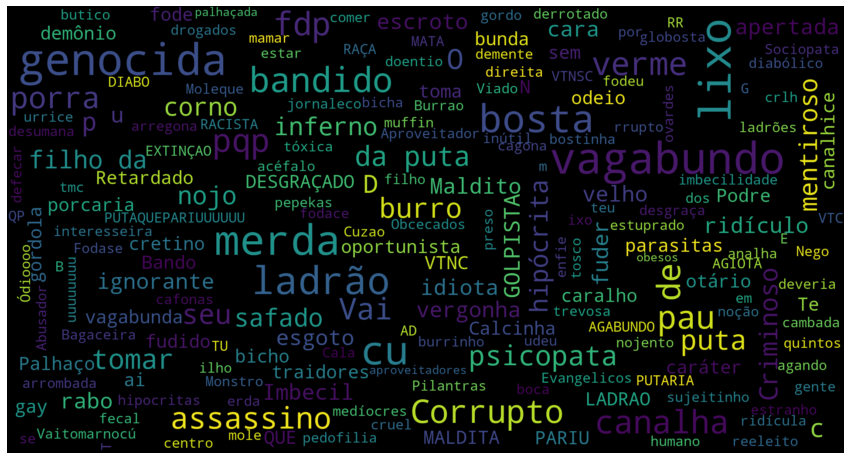

In [13]:
wc = WordCloud(width=1920, height=1024,
               max_words=200, max_font_size=100)

wc.generate(" ".join(toxic_substrs))

plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
data[data["toxic_spans"].isnull()]["text"].tolist()

['USER O partido do Kim votou à favor do fundão. Mas o machão fica quietinho.',
 'USER Então porque as professoras,as políticas femininas ganham um salário de miséria',
 'USER USER Tu nem podia tá falando aí condenado em primeira e segunda estância',
 'USER Esquerda querendo falar de corrupção É de matar kkkk',
 'USER Que ódio, já amei!',
 'USER USER',
 'USER Tão bonitinho, vai sofre tanto tadinho',
 'USER USER to sentindo q esse cara vai fazer história',
 'USER tadeu roubou a gimmick do sammy g USER',
 '🏆 Categoria: MEU B.O. FAVORITO 🏆 E os vencedores são: Gilberto, Pocah e a treta do basculho Assista AO VIVO ao HASHTAG → URL HASHTAG HASHTAG URL',
 'RT USER: A treta está intensa por aqui! Segundo o USER, a USER não se aproxima dele por medo do público.…',
 'RT USER: O time vencedor deverá mostrar que entende de proteína suína! Para quem vai a sua torcida? HASHTAG Ana G., Manu…',
 'RT USER: O Fazendeiro USER já pensa em como irá fazer para delegar novamente a tarefa da peoa que será el